In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1. Load the clean data
df = pd.read_csv('../data/clinical_trials_clean.csv')

# 2. Select features (X) and target (y)
# We pick 'enrollment', 'phase', and 'sponsor_type' because they are clean
features = ['enrollment', 'phase', 'sponsor_type']
target = 'target'

X = df[features]
y = df[target]

print("Original Features:")
display(X.head())

Original Features:


,enrollment,phase,sponsor_type
0,78.0,PHASE1,INDUSTRY
1,100.0,NaN,OTHER
2,46.0,NaN,OTHER
3,0.0,NaN,INDUSTRY
4,0.0,NaN,INDUSTRY


In [2]:
# 1. Handle Missing Values (Imputation)
# If phase is missing, call it 'UNKNOWN'
X['phase'] = X['phase'].fillna('UNKNOWN')

# If enrollment is missing, fill it with the median number (safe bet)
X['enrollment'] = X['enrollment'].fillna(X['enrollment'].median())

# 2. Convert text to numbers (One-Hot Encoding)
# drop_first=True avoids redundancy (e.g., if it's not Phase 1, 2, or 3, it must be 4)
X_encoded = pd.get_dummies(X, columns=['phase', 'sponsor_type'], drop_first=True)

print("Fixed Missing Values & Encoded Data:")
display(X_encoded.head())

Fixed Missing Values & Encoded Data:


C:\Users\NITIN SAVIO BADA\AppData\Local\Temp\ipykernel_1608\812527080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['phase'] = X['phase'].fillna('UNKNOWN')
C:\Users\NITIN SAVIO BADA\AppData\Local\Temp\ipykernel_1608\812527080.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['enrollment'] = X['enrollment'].fillna(X['enrollment'].median())


,enrollment,phase_PHASE1,phase_PHASE1/PHASE2,phase_PHASE2,phase_PHASE2/PHASE3,phase_PHASE3,phase_PHASE4,phase_UNKNOWN,sponsor_type_INDUSTRY,sponsor_type_NETWORK,sponsor_type_NIH,sponsor_type_OTHER,sponsor_type_OTHER_GOV
0,78.0,True,False,False,False,False,False,False,True,False,False,False,False
1,100.0,False,False,False,False,False,False,True,False,False,False,True,False
2,46.0,False,False,False,False,False,False,True,False,False,False,True,False
3,0.0,False,False,False,False,False,False,True,True,False,False,False,False
4,0.0,False,False,False,False,False,False,True,True,False,False,False,False


In [3]:
# 1. Split the data
# test_size=0.2 means 20% goes to the test pile
# stratify=y means "Make sure both piles have the same % of Successes and Failures"
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# 2. Check the size of the piles
print(f"TRAINING Data: {X_train.shape[0]} trials (The Study Guide)")
print(f"TESTING Data:  {X_test.shape[0]} trials (The Final Exam)")

TRAINING Data: 548 trials (The Study Guide)
TESTING Data:  138 trials (The Final Exam)


In [5]:
# 1. Initialize the model
# class_weight='balanced' is CRITICAL because we have way more Successes than Failures.
# It tells the model: "Pay extra attention to failures!"
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# 2. Train on the Study Guide (X_train, y_train)
model.fit(X_train, y_train)

# 3. Take the Final Exam (Predict on X_test)
y_pred = model.predict(X_test)

print(" Model Training Complete.")

 Model Training Complete.


--- Model Performance Report ---
              precision    recall  f1-score   support

           0       0.29      0.61      0.39        23
           1       0.90      0.70      0.78       115

    accuracy                           0.68       138
   macro avg       0.59      0.65      0.59       138
weighted avg       0.80      0.68      0.72       138



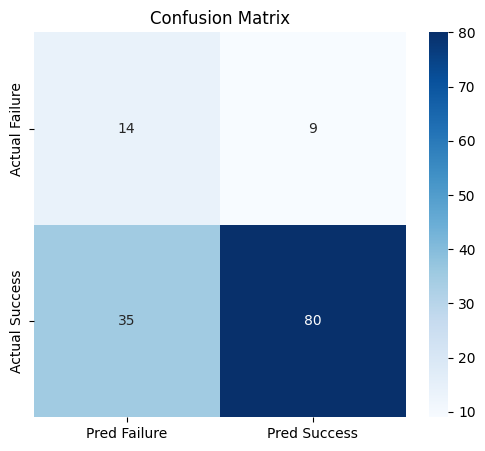

In [6]:
# Print the report card
print("--- Model Performance Report ---")
print(classification_report(y_test, y_pred))

# Visualizing the Confusion Matrix
# (Top Left = Correctly Predicted Failures)
# (Bottom Right = Correctly Predicted Successes)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Failure', 'Pred Success'],
            yticklabels=['Actual Failure', 'Actual Success'])
plt.title("Confusion Matrix")
plt.show()

--- What drives Success vs Failure? ---


,Feature,Weight
5,phase_PHASE3,-1.465961
8,sponsor_type_INDUSTRY,-1.057470
2,phase_PHASE1/PHASE2,-0.905370
9,sponsor_type_NETWORK,-0.844339
11,sponsor_type_OTHER,-0.569839
3,phase_PHASE2,-0.125879
6,phase_PHASE4,-0.086074
10,sponsor_type_NIH,-0.040754
0,enrollment,0.007985
4,phase_PHASE2/PHASE3,0.388038


C:\Users\NITIN SAVIO BADA\AppData\Local\Temp\ipykernel_1608\56386411.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefficients, x='Weight', y='Feature', palette='coolwarm')


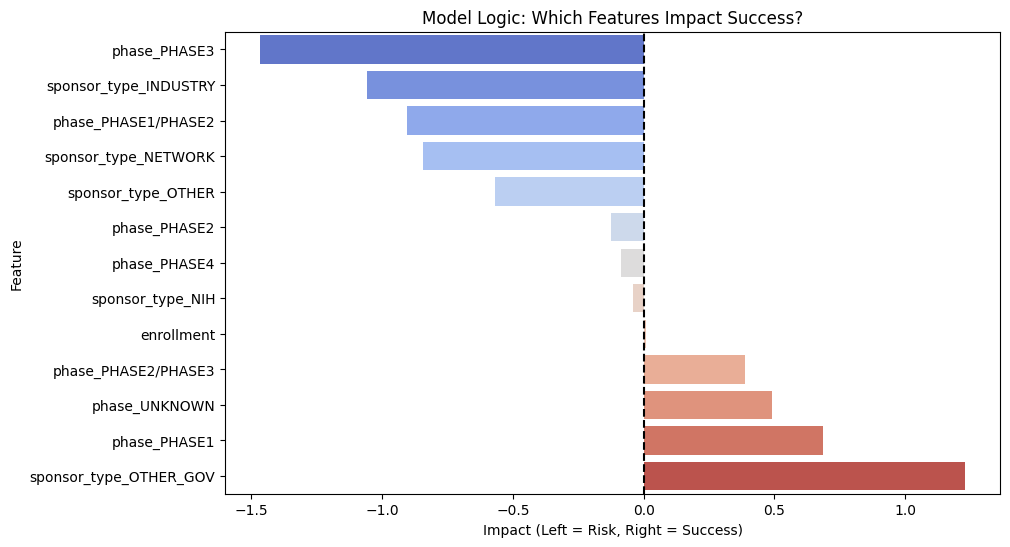

In [7]:
# Get the "weights" the model learned
coefficients = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Weight': model.coef_[0]
})

# Sort them to see the biggest drivers
coefficients = coefficients.sort_values(by='Weight', ascending=True)

print("--- What drives Success vs Failure? ---")
# Negative Weight = Drives Failure
# Positive Weight = Drives Success
display(coefficients)

# Visualize it
plt.figure(figsize=(10, 6))
sns.barplot(data=coefficients, x='Weight', y='Feature', palette='coolwarm')
plt.title("Model Logic: Which Features Impact Success?")
plt.xlabel("Impact (Left = Risk, Right = Success)")
plt.axvline(x=0, color='black', linestyle='--') # Add a center line
plt.show()

In [8]:
import joblib
import os

# Create the models folder if it doesn't exist yet
if not os.path.exists('../models'):
    os.makedirs('../models')

# Define the path
model_filename = '../models/baseline_logreg.pkl'

# Save the model
joblib.dump(model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to ../models/baseline_logreg.pkl
